From [speech processing tutorial](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

- ``Mel-Frequency Cepstral Coefficients (MFCCs), filter banks``
- **Steps:**
    * Pre-emphasis filter
    * Sliced into frames and a window is applied to each frame
    * Fourier transform on each frame (Short-Time Fourier Transform) $\Rightarrow$ Calculate the power spectrum
    * Compute **filter banks**
- **For MFCCs**
    * Apply Discrete Cosine Transform (DCT) to the filter banks $\Rightarrow$ Retain a number of the resulting coefficients (discard the rest)
- The final step in both cases: **``mean normalization``**
> **``sample rate``**`` is the number of data point sampled in each second``

In [1]:
import numpy as np
import scipy.io.wavfile
import librosa
from scipy.fftpack import dct
import matplotlib.pyplot as plt

/home/thanhpv21/.local/lib/python3.7/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
audio_pth = './audio/SA1.WAV'

In [3]:
signal, sr = librosa.load(audio_pth)

In [4]:
sr, signal.shape

(22050, (64493,))

In [5]:
duration = signal.shape[0]/sr
print ("Audio duration = %.2f seconds - %.2f" %(duration, librosa.get_duration(signal, sr = sr)))

Audio duration = 2.92 seconds - 2.92


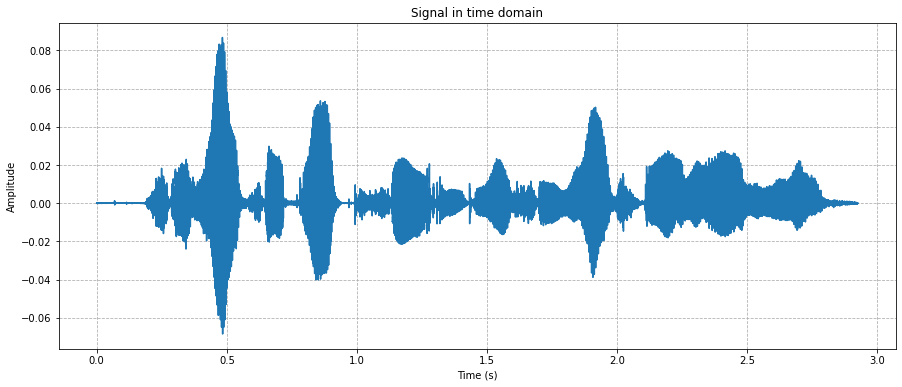

In [15]:
len_ = np.linspace(0, duration, signal.shape[0])
plt.figure(figsize=(15, 6))
plt.plot(len_, signal)
plt.grid(linestyle='dashed')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal in time domain")
plt.show()

## Pre-Emphasis

**Usage of pre-emphasis**
* Balance the frequency spectrum (high frequencies usually have smaller magnitudes compared to lower frequencies)
* Avoid numerical problems during Fourier transform operation
* improve the Signal-to-Noise Ratio (SNR)
$$y(t) = x(t) - \alpha x(t-1)$$
$\alpha$ is pre emphasis value

In [7]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

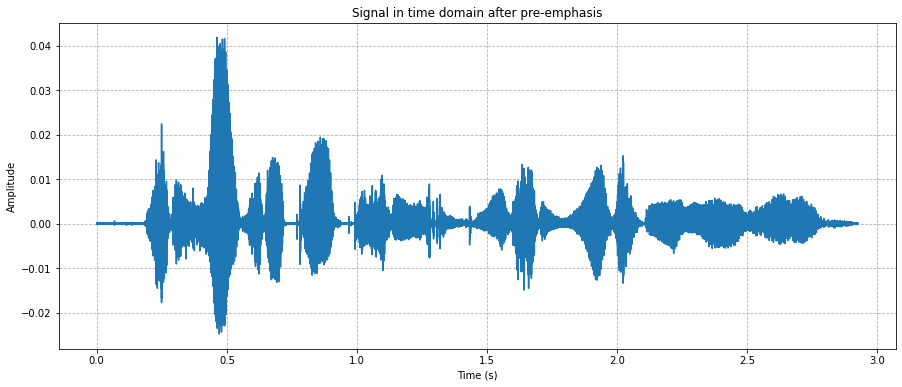

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(len_, emphasized_signal)
plt.grid(linestyle = "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal in time domain after pre-emphasis")
plt.show()

### Framing
- Split the signal into short-time frames.
- Rationale: frequencies in a signal change over time, so in most cases, it does not make sense to do Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time.
- We can assume that frequencies in a signal are stationary over a short period of time.
- Doing Fourier transform over this short-time frame $\Rightarrow$ obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames

- Typical frame sizes in speech processing range from 20ms to 40ms with 50% (+/-10%) overlap between consecutive frames.
    * Popular frame size: 25ms, stride: 10ms (15ms overlap)